In [86]:
import numpy as np
#Lab Tools package from Werner Boeglin, FIU
import LT.box as B
from Model import BP
from Model import BLin

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
import iminuit.cost as cost


# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
import copy 

In [87]:
# load historgram

#For smaller range use the one below
#h = B.histo2d(file = 'Metaprime_Momega_totalMC_rebin_diffrange_new.data')
h = B.histo2d(file = 'Metaprime_Momega_omegaMC_rebin_origrange.data')


# get bin centers of above histogram
xb = h.x_bin_center
yb = h.y_bin_center

# get bin edges of above histogram
xbe = h.x_bins
ybe = h.y_bins

# Define function for Least Square fit

In [88]:
# fit 2 Gaussians to etaprime and single Gaussian to omega
#Limits for fit paramters
no_bound = [-np.inf, np.inf]
is_pos =   [1e-6, np.inf]
is_prob = [1e-6, 1.]


# initial values
IV = {}


# omega peak
IV['x0'] = [0.780, [0.775, 0.785]]
IV['sig_x'] = [0.0129, [0.008, 0.02]]

# omega amplitude as a function of etap mass 
IV['cy0'] = [0.07, is_pos]
IV['cy1'] = [0.1, is_pos]
IV['cy2'] = [0.1, is_pos]


# eta peak
IV['x0e'] = [0.555, [0.545, 0.565]]
IV['sig_xe'] = [0.0143, [0.005, 0.015]]

# eta amplitude as a function of etap mass 
IV['cye0'] = [0., is_pos]
IV['cye1'] = [0., is_pos]
IV['cye2'] = [0., is_pos]

# etap peak
IV['y0'] = [0.957, [0.955, 0.965]]
IV['sig_y'] = [0.658, [0.006, 0.015]]
IV['co_A'] = [0.5, [0,0.5]]
IV['co_sig_y'] = [0.52, [0,50]]
 

# etap Amplitude as a function of omega mass
IV['cx0'] = [0., is_pos]
IV['cx1'] = [10., is_pos]
IV['cx2'] = [10., is_pos]
IV['cx3'] = [10., is_pos]


# backgrpound paramters z-value at the edges
xr = [xbe.min(), xbe.max()]
yr = [ybe.min(), ybe.max()]

IV['z1'] = [0.9480, is_pos]
IV['z2'] = [1.404, is_pos]
IV['z3'] = [2.2843, is_pos]
IV['z4'] = [2.813, is_pos]

ZP = [IV['z1'][0], IV['z2'][0], IV['z3'][0], IV['z4'][0]]


# fractions for extended unbinned likelihood fit
IV['o']    = [25, is_pos]
IV['e']  = [0., is_pos]
IV['ep'] = [25, is_pos]
IV['b']  = [25, is_pos]

#Interval for Bernstein polynomials
interv_x = [xbe.min(), xbe.max()]
interv_y = [ybe.min(), ybe.max()]

# Bernstein polynomial for etap amplitude
BP_etap = BP(8, interv_x)

# Bernstein polynomial for omega amplitude
BP_omega = BP(2, interv_y)
 

# bi-linear background
Bckg = BLin(xr, yr, ZP)

[[<matplotlib.lines.Line2D at 0x1672b2f80>],

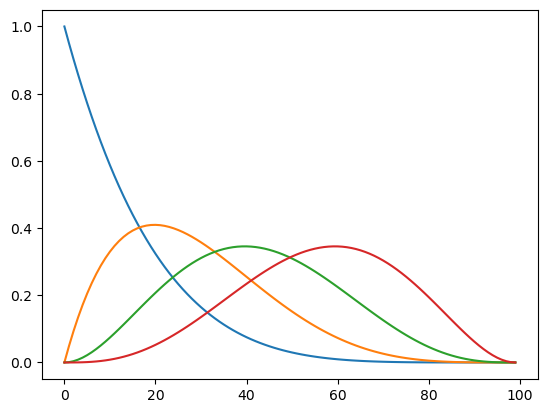

In [89]:
#Visualizing different polynomials

pol5=BP(5)
points=np.linspace(0,1,100)
B.pl.figure()
[B.pl.plot(pol5[i](points)) for  i in [0,1,2,3]]

In [90]:
#For details check https://iminuit.readthedocs.io/en/stable/notebooks/cost_functions.html
# Dependence on etaprime mass is denoted by y and dependence on omega mass denoted by x    
def F_Omega(x,y,cy0,cy1,cy2,x0,sig_x):

    Amp_omega=(cy0*BP_omega[0](y)+cy1*BP_omega[1](y)+cy2*BP_omega[2](y))
    Dist_omega=np.exp(-(x - x0)**2/(2*sig_x**2))
    return Amp_omega*Dist_omega



def F_Eta(x,y,cye0,cye1,cye2,x0e,sig_xe):

    Amp_eta=(cye0*BP_omega[0](y)+cye1*BP_omega[1](y)+cye2*BP_omega[2](y))
    Dist_eta=np.exp(-(x - x0e)**2/(2*sig_xe**2))
    return Amp_eta*Dist_eta



def F_2Gaus(x,x0,sig,co_A,co_sig):
    
    return np.exp(-(x - x0)**2/(2*sig**2)) + co_A*np.exp(-(x - x0)**2/(2*(co_sig*sig)**2))
    



def F_Etprime(x,y,cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y):

    Amp_etap=(cx0*BP_etap[1](x)+cx1*BP_etap[3](x)+cx2*BP_etap[5](x)+cx3*BP_etap[6](x))
    Dist_etap=F_2Gaus(y,y0,sig_y,co_A,co_sig_y)
    return Amp_etap*Dist_etap


def Bckg_PDF(x,y,z1,z2,z3,z4):

    return Bckg.Get_value(x,y,z1,z2,z3,z4)






In [97]:
#Create grid of x and y values
Y,X=np.meshgrid(yb,xb)


#Flatten created arrays
XF=X.flatten()
YF=Y.flatten()


#Create array of indexes
Ind=np.arange(YF.shape[0])

#Flatten arrays of histogram bin contents and errors
CF = h.bin_content.flatten()
EF = h.bin_error.flatten()


#Choose indexes corresponding to non 0 bin contents
S_ind=CF> 0
Sel_Ind=Ind[S_ind]
Sel_CF=CF[S_ind]
Sel_EF=EF[S_ind]



#Define fit function
def F_sum(x,cy0,cy1,cy2,x0,sig_x,\
          cye0,cye1,cye2,x0e,sig_xe,\
          cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y,\
          z1,z2,z3,z4):
    
    ind=x.astype(int)
    xx=XF[ind]
    yy=YF[ind]

    
    fsum=F_Omega(xx,yy,cy0,cy1,cy2,x0,sig_x)+\
    F_Eta(xx,yy,cye0,cye1,cye2,x0e,sig_xe)+\
    F_Etprime(xx,yy,cx0,cx1,cx2,cx3,y0,sig_y,co_A,co_sig_y)+\
    Bckg_PDF(xx,yy,z1,z2,z3,z4)
    
    return fsum

    
#List of argument names    
arg_names=['cy0','cy1','cy2','x0','sig_x',\
          'cye0','cye1','cye2','x0e','sig_xe',\
          'cx0','cx1','cx2','cx3','y0','sig_y','co_A','co_sig_y',\
          'z1','z2','z3','z4']



In [98]:
# iminuit contains a LeastSquares class 

Least_sq = LeastSquares(Sel_Ind, Sel_CF, Sel_EF, F_sum)

# initialize values
init_values = [IV[k][0] for k in arg_names]
Mi = Minuit(Least_sq,  *init_values)

# set the bounds
for k in arg_names:
    Mi.limits[k] = IV[k][1]
    
#fix eta amplitude
Mi.fixed["cye0"]= True
Mi.fixed["cye1"]= True
Mi.fixed["cye2"]= True
Mi.fixed['x0e']= True
Mi.fixed['sig_xe']= True


In [99]:
Mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1915 (chi2/ndof = 0.9)     │             Nfcn = 1453              │
│ EDM = 1.72e-05 (Goal: 0.0002)    │            time = 5.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ cy0      │    4.0    │    0.8    │            │            │  1e-06  │         │       │
│ 1 │ cy1      │   29.2    │    2.1    │            │            │  1e-06  │         │       │
│ 2 │ cy2      │   79.1    │    2.0    │            │            │  1e-06  │         │       │
│ 3 │ x0       │ 781.29e-3 │  0.20e-3  │            │            │  0.775  │  0.785  │       │
│ 4 │ sig_x    │ 13.69e-3  │  0.18e-3  │            │            │  0.008  │  0.02   │       │
│ 5 │ cye0     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 6 │ cye1     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 7 │ cye2     │    0.0    │    0.1    │            │            │  1e-06  │         │  yes  │
│ 8 │ x0e      │   0.555   │   0.006   │            │            │  0.545  │  0.565  │  yes  │
│ 9 │ sig_xe   │ 14.30e-3  │  0.14e-3  │            │            │  0.005  │  0.015  │  yes  │
│ 10│ cx0      │    8.9    │    0.8    │            │            │  1e-06  │         │       │
│ 11│ cx1      │   117.1   │    2.4    │            │            │  1e-06  │         │       │
│ 12│ cx2      │    0.6    │    1.3    │            │            │  1e-06  │         │       │
│ 13│ cx3      │    4.5    │    1.3    │            │            │  1e-06  │         │       │
│ 14│ y0       │ 957.75e-3 │  0.06e-3  │            │            │  0.955  │  0.965  │       │
│ 15│ sig_y    │  7.24e-3  │  0.08e-3  │            │            │  0.006  │  0.015  │       │
│ 16│ co_A     │   0.500   │   0.014   │            │            │    0    │   0.5   │       │
│ 17│ co_sig_y │   0.481   │   0.027   │            │            │    0    │   50    │       │
│ 18│ z1       │   0.83    │   0.21    │            │            │  1e-06  │         │       │
│ 19│ z2       │   0.53    │   0.30    │            │            │  1e-06  │         │       │
│ 20│ z3       │   1.38    │   0.26    │            │            │  1e-06  │         │       │
│ 21│ z4       │   1.27    │   0.18    │            │            │  1e-06  │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │       cy0       cy1       cy2        x0     sig_x      cye0      cye1      cye2       x0e    sig_xe       cx0       cx1       cx2       cx3        y0     sig_y      co_A  co_sig_y        z1        z2        z3        z4 │
├──────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

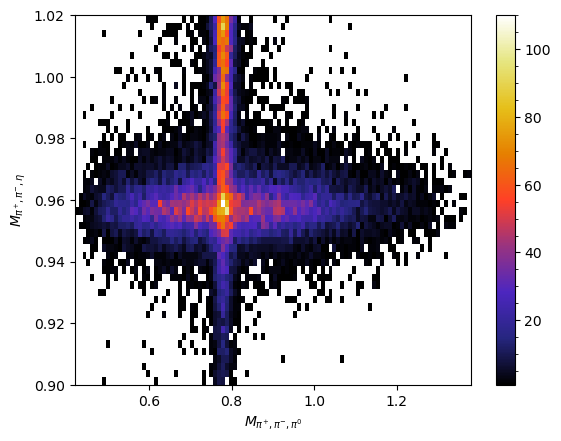

In [100]:
B.pl.figure()
h.plot()

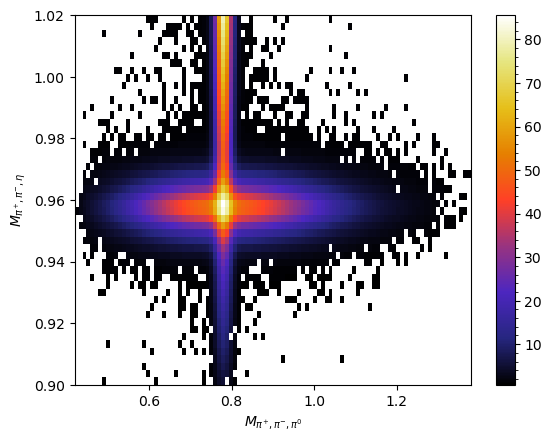

In [101]:
SF = np.zeros_like(CF)
# calculate the fitted values
# setup histogram for fitted values
SF[Sel_Ind] = F_sum(Sel_Ind, *Mi.values)

# setup histogram for fitted values
h_fit = copy.copy(h)
h_fit.bin_content = np.zeros_like(h.bin_content)
h_fit.bin_error = np.ones_like(h.bin_content)
h_fit.bin_content = SF.reshape(X.shape)
B.pl.close('all');h_fit.plot()

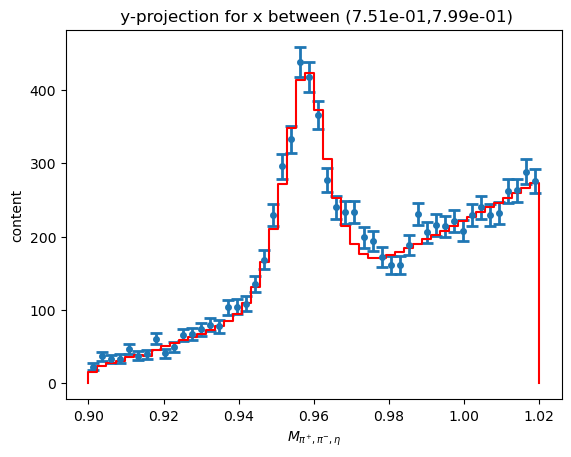

In [102]:
#%% compare etap projection

B.pl.figure()
o_range = (0.75, 0.8)

h.project_y(range = o_range).plot_exp()
h_fit.project_y(range = o_range).plot(filled = False, color = 'r')

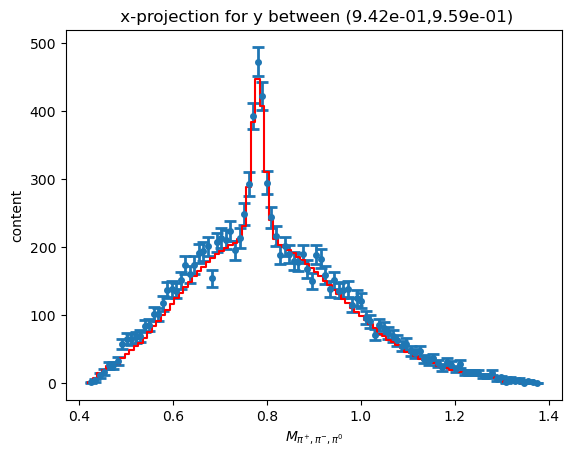

In [103]:
B.pl.figure()
e_range = (0.94, 0.96)

h.project_x(range = e_range).plot_exp()
h_fit.project_x(range = e_range).plot(filled = False, color = 'r')